In [1]:
import models
from models import model, create_cd_cluster
from dataset_management import get_dataset, convert_to_autorank
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";time="used_fidelity"
algos=["pb_mutation_dynamic_geometric-default-at-target","random_search","hyperband"]
#fs=[24]
#f_space=np.linspace(1,max(fs),max(fs)).tolist()
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PB+BO"}

data=get_dataset(dataset_name="fig5_24_at25_bad_intsteps")

In [2]:
from pymer4 import Lmer,Lm
loss="value"
model_lmer = Lm(
    formula=f"{loss}~{algorithm}",
    data=data,
)
factors={algorithm: list(data[algorithm].unique())}
model_lmer.fit(
    factors=factors,
    REML=False,
    summarize=False,
    verbose=False,
)

data["dummy"] = "0"
data.at[data.index[5555],"dummy"] = "1"

model_lm = Lmer(
    formula=f"{loss}~{algorithm}+(1|dummy)",
    data=data,
)
factors={algorithm: list(data[algorithm].unique())}
model_lm.fit(
    factors=factors,
    REML=False,
    summarize=False,
    verbose=False,
)

print(model_lmer.summary(),"\n")
print(model_lm.summary())


boundary (singular) fit: see help('isSingular') 

Formula: value~algorithm

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 86400	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -269924.244 	 AIC: 539854.489	 BIC: 539882.589

Fixed effects:

                 Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
Intercept           2.263   2.200    2.327  0.032  86397  69.808  0.000  ***
algorithm[T.PB]     0.293   0.203    0.383  0.046  86397   6.397  0.000  ***
algorithm[T.RS]    -0.100  -0.190   -0.010  0.046  86397  -2.182  0.029    * 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value~algorithm+(1|dummy)

Family: gaussian	 Inference: parametric

Number of observations: 86400	 Groups: {'dummy': 2.0}

Log-likelihood: -269924.244 	 AIC: 539858.489

Random effects:

                 Name     Var    Std
dummy     (Intercept)   0.000  0.000
Residual               30.276  5.502

No random 

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates


c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-v

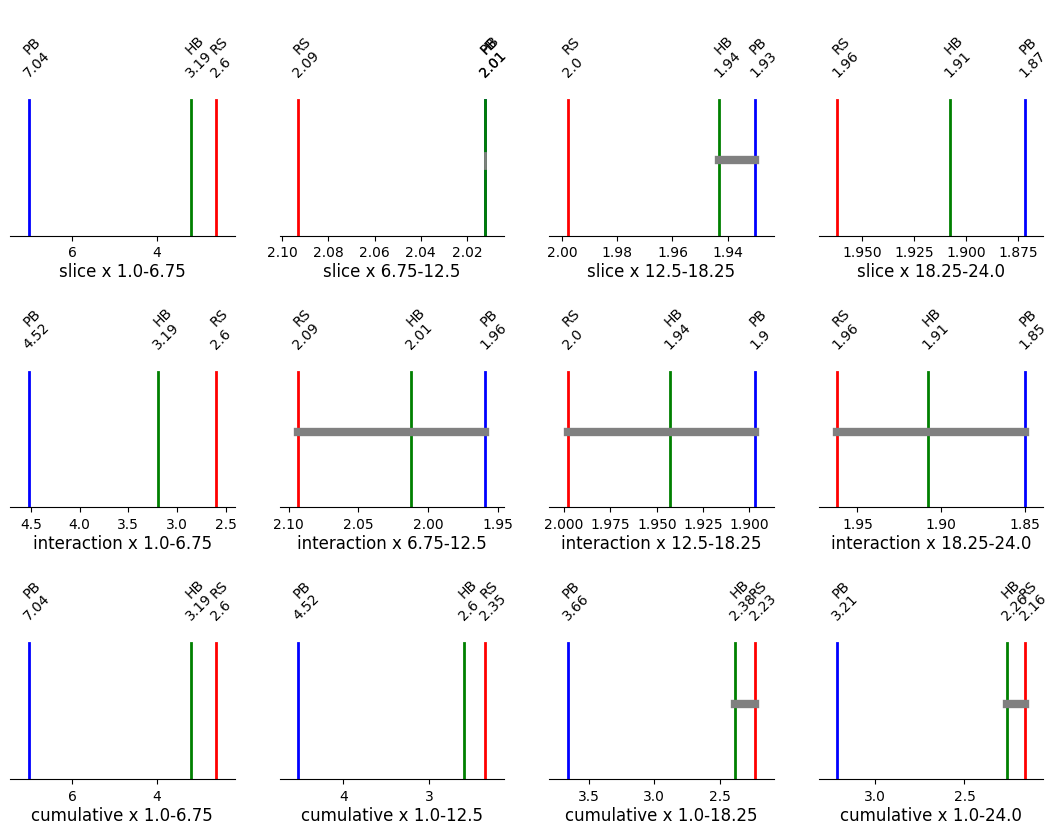

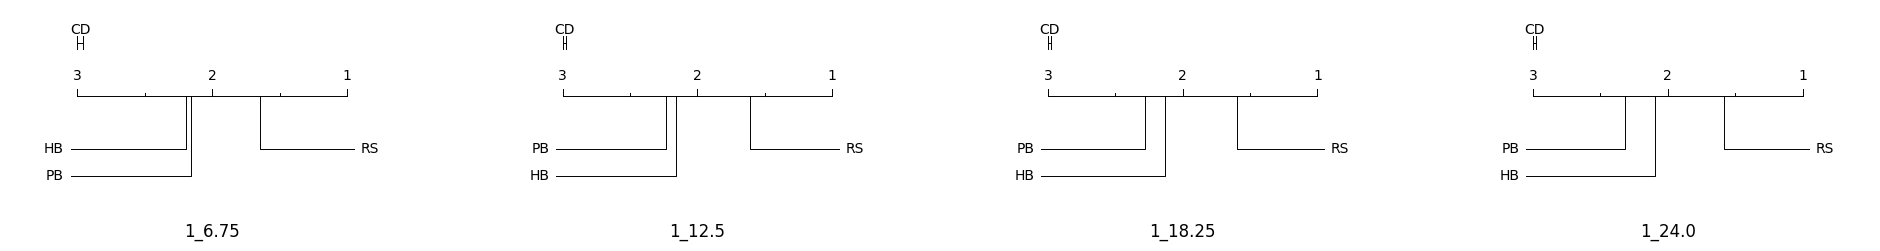

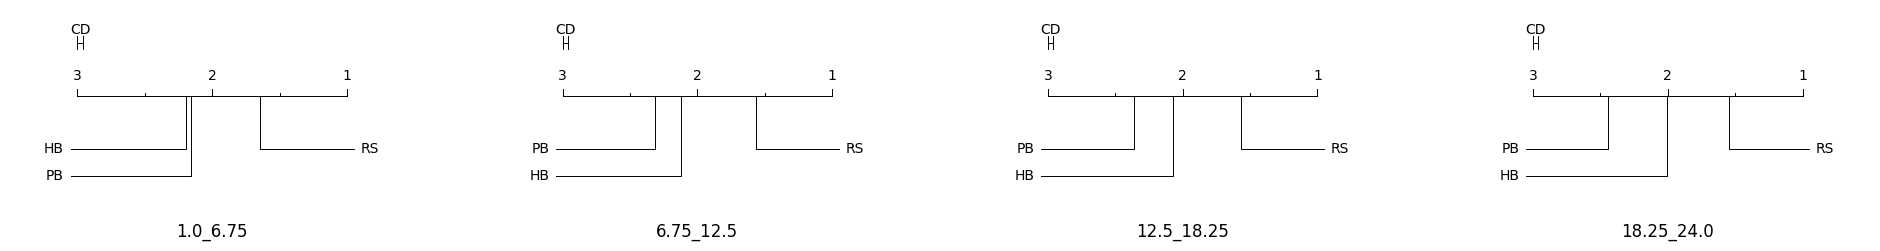

In [3]:
loss="value"
data_t=data.loc[data[benchmark].str.contains("bad")]
time_slices=list(np.linspace(1,24,5).round(2))
data_slices=[]
labels=[]
result_cluster={"slice":{}}
for t_n,t in enumerate(time_slices[:-1]):
    labels.append(f"{t}-{time_slices[t_n+1]}")
    data_slices.append(data_t.loc[(data_t[time]>=t)&(data_t[time]<time_slices[t_n+1]+0.1)])
    post_hocs=model(formula=f"{loss}~{algorithm}+(1|{benchmark})",data=data_slices[-1]).post_hoc(marginal_vars=algorithm)
    result_cluster["slice"][f"{t}-{time_slices[t_n+1]}"]=post_hocs
data_binned=data
data_binned[f"{time}_bins"] = pd.cut(
            data[time],
            bins=time_slices,
            labels=labels,
            include_lowest=True,
            right=True,
        ).astype(str)
post_hocs=model(formula=f"{loss}~{algorithm}+ {time}_bins + {algorithm}:{time}_bins +(1|{benchmark})",data=data_binned,factor=f"{time}_bins").post_hoc(marginal_vars=algorithm, grouping_vars=f"{time}_bins")
result_cluster["interaction"]={}
for t in labels:
    result_cluster["interaction"][t]=(post_hocs[0].query(f"{time}_bins == '{t}'"),post_hocs[1].query(f"{time}_bins == '{t}'"))


result_cluster["cumulative"]={}
data_inc_bins={}
for s_n,slice in enumerate(time_slices[:-2]):
    data_inc_bins[slice]=data_t
    new_slices=[time_slices[0]]+time_slices[s_n+1:]
    new_labels=[f"{time_slices[0]}-{time_slices[s_n+1]}"]+labels[s_n+1:]
    data_inc_bins[slice][f"{time}_bins"] = pd.cut(
                data_inc_bins[slice][time],
                bins=new_slices,
                labels=new_labels,
                include_lowest=True,
                right=True,
            ).astype(str)
    post_hocs=model(formula=f"{loss}~{algorithm}+ {time}_bins + {algorithm}:{time}_bins +(1|{benchmark})",data=data_inc_bins[slice],factor=f"{time}_bins").post_hoc(marginal_vars=algorithm, grouping_vars=f"{time}_bins")
    result_cluster["cumulative"][new_labels[0]]=(post_hocs[0].query(f"{time}_bins == '{new_labels[0]}'"),post_hocs[1].query(f"{time}_bins == '{new_labels[0]}'"))
result_cluster["cumulative"][f"{time_slices[0]}-{time_slices[-1]}"]=model(formula=f"{loss}~{algorithm}+(1|{benchmark})",data=data_t).post_hoc(marginal_vars=algorithm)

fig,axes = create_cd_cluster(result_cluster, show=False)
fig_top,axes_top= plt.subplots(
        1,len(axes[0]),figsize=(max(fig.get_figwidth(),6*len(axes[0])),fig.get_figheight()/len(axes[0])))
fig_bot,axes_bot= plt.subplots(
        1,len(axes[0]),figsize=(max(fig.get_figwidth(),6*len(axes[0])),fig.get_figheight()/len(axes[0])))
autorank_results={}
for ax_n,ax in enumerate(axes_top):
    autorank_data=convert_to_autorank(data.loc[data["used_fidelity"]<=time_slices[ax_n+1]])
    autorank_results[f"1_{time_slices[ax_n+1]}"]=autorank(autorank_data)
    ax=plot_stats(autorank_results[f"1_{time_slices[ax_n+1]}"],ax=ax,allow_insignificant=True)
    ax.set_title(f"1_{time_slices[ax_n+1]}", pad=0, y=-0.18)
    autorank_data=convert_to_autorank(data.loc[(data["used_fidelity"]>=time_slices[ax_n])&(data["used_fidelity"]<=time_slices[ax_n+1])])
    autorank_results[f"{time_slices[ax_n]}_{time_slices[ax_n+1]}"]=autorank(autorank_data)
    axes_bot[ax_n]=plot_stats(autorank_results[f"{time_slices[ax_n]}_{time_slices[ax_n+1]}"],ax=axes_bot[ax_n],allow_insignificant=True)
    axes_bot[ax_n].set_title(f"{time_slices[ax_n]}_{time_slices[ax_n+1]}", pad=0, y=-0.18)
plt.show()


boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates


c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "used_fidelity_bins". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'numpy.str_'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates


c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


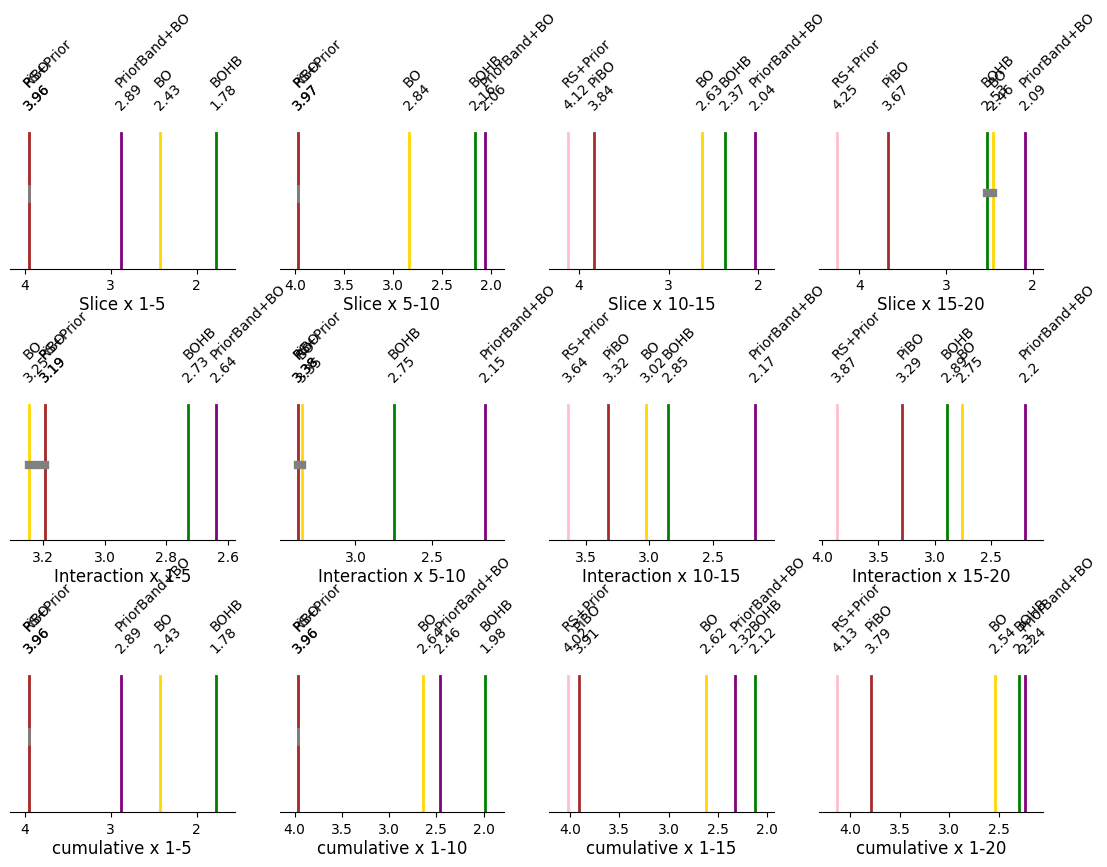

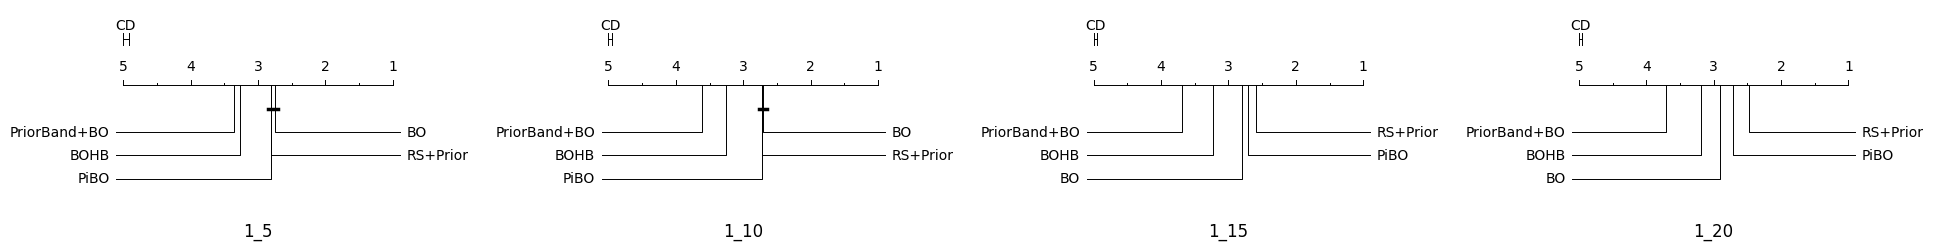

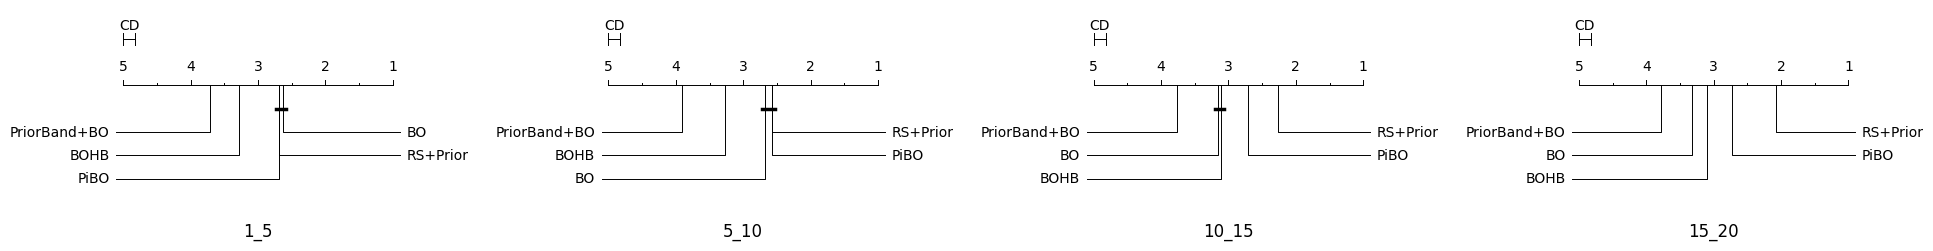

In [8]:
loss="rel_rank"
data=data=get_dataset(dataset_name="fig7_24_at25_bad_intsteps")
data_t=data.loc[data[benchmark].str.contains("bad")]
time_slices=[1,5,10,15,20]#list(np.linspace(1,24,5).round(2))
data_slices=[]
labels=[]
result_cluster={"Slice":{}}
for t_n,t in enumerate(time_slices[:-1]):
    labels.append(f"{t}-{time_slices[t_n+1]}")
    data_slices.append(data_t.loc[(data_t[time]>=t)&(data_t[time]<time_slices[t_n+1]+0.1)])
    post_hocs=model(formula=f"{loss}~{algorithm}+(1|{benchmark})",data=data_slices[-1]).post_hoc(marginal_vars=algorithm)
    result_cluster["Slice"][f"{t}-{time_slices[t_n+1]}"]=post_hocs
data_binned=data
data_binned[f"{time}_bins"] = pd.cut(
            data[time],
            bins=time_slices,
            labels=labels,
            include_lowest=True,
            right=True,
        ).astype(str)
post_hocs=model(formula=f"{loss}~{algorithm}+ {time}_bins + {algorithm}:{time}_bins +(1|{benchmark})",data=data_binned,factor=f"{time}_bins").post_hoc(marginal_vars=algorithm, grouping_vars=f"{time}_bins")
result_cluster["Interaction"]={}
for t in labels:
    result_cluster["Interaction"][t]=(post_hocs[0].query(f"{time}_bins == '{t}'"),post_hocs[1].query(f"{time}_bins == '{t}'"))

result_cluster["cumulative"]={}
data_inc_bins={}
for s_n,slice in enumerate(time_slices[:-2]):
    data_inc_bins[slice]=data_t
    new_slices=[time_slices[0]]+time_slices[s_n+1:]
    new_labels=[f"{time_slices[0]}-{time_slices[s_n+1]}"]+labels[s_n+1:]
    data_inc_bins[slice][f"{time}_bins"] = pd.cut(
                data_inc_bins[slice][time],
                bins=new_slices,
                labels=new_labels,
                include_lowest=True,
                right=True,
            ).astype(str)
    post_hocs=model(formula=f"{loss}~{algorithm}+ {time}_bins + {algorithm}:{time}_bins +(1|{benchmark})",data=data_inc_bins[slice],factor=f"{time}_bins").post_hoc(marginal_vars=algorithm, grouping_vars=f"{time}_bins")
    result_cluster["cumulative"][new_labels[0]]=(post_hocs[0].query(f"{time}_bins == '{new_labels[0]}'"),post_hocs[1].query(f"{time}_bins == '{new_labels[0]}'"))
result_cluster["cumulative"][f"{time_slices[0]}-{time_slices[-1]}"]=model(formula=f"{loss}~{algorithm}+(1|{benchmark})",data=data_t).post_hoc(marginal_vars=algorithm)

fig,axes = create_cd_cluster(result_cluster, show=False)
fig_top,axes_top= plt.subplots(
        1,len(axes[0]),figsize=(max(fig.get_figwidth(),6*len(axes[0])),fig.get_figheight()/len(axes[0])))
fig_bot,axes_bot= plt.subplots(
        1,len(axes[0]),figsize=(max(fig.get_figwidth(),6*len(axes[0])),fig.get_figheight()/len(axes[0])))
autorank_results={}
for ax_n,ax in enumerate(axes_top):
    autorank_data=convert_to_autorank(data.loc[data["used_fidelity"]<=time_slices[ax_n+1]])
    autorank_results[f"1_{time_slices[ax_n+1]}"]=autorank(autorank_data)
    ax=plot_stats(autorank_results[f"1_{time_slices[ax_n+1]}"],ax=ax,allow_insignificant=True)
    ax.set_title(f"1_{time_slices[ax_n+1]}", pad=0, y=-0.18)
    autorank_data=convert_to_autorank(data.loc[(data["used_fidelity"]>=time_slices[ax_n+1])&(data["used_fidelity"]<=time_slices[ax_n+1])])
    autorank_results[f"{time_slices[ax_n]}_{time_slices[ax_n+1]}"]=autorank(autorank_data)
    axes_bot[ax_n]=plot_stats(autorank_results[f"{time_slices[ax_n]}_{time_slices[ax_n+1]}"],ax=axes_bot[ax_n],allow_insignificant=True)
    axes_bot[ax_n].set_title(f"{time_slices[ax_n]}_{time_slices[ax_n+1]}", pad=0, y=-0.18)
plt.show()
